_This notebook contains code and comments from Section 5.1 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 5.1	Gradient Descent for Minimization

When learning a machine learning model, we typically aim to find the model that fits the training data. The "goodness of this fit" is measured using the loss function. Model training is essentially finding the model parameters that minimize the loss function. Training of most machine learning algorithms can ultimately be cast into this framework, and attemtp to minimize the loss function in many different ways.

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is one such way. It is an iterative technique that can be used to find the (local) minimimum of an objective function. It is an example of a first-order optimization technique as it uses first-derivative information, that is, the gradient.


---
### 5.1.1 Gradient Descent with an Illustrative Example
We will use the [Branin function](https://uqworld.org/t/branin-function/53) as a test function to visualize how gradient descent works. The Branin function is a function of two variables $w_1$ and $w_2$:

\\[
f(w_1, w_2) = a (w_2 - b w_1^2 + c w_1 - r)^2 + s (1-t) \cos{w_1} + s
\\]

Since we will be performing gradient descent, we will need the gradient of $f(w_1, w_2)$ with respect to both $w_1$ and $w_2$, which we collect into a two dimensional vector:

\\[
g(w_1, w_2) = \left[ \begin{array}{c} 
    \frac{\partial f(w_1, w_2)}{\partial w_1} \\ 
    \frac{\partial f(w_1, w_2)}{\partial w_2} 
    \end{array} \right] 
    = \left[ \begin{array}{c} 
    2a(w_2 - b w_1^2 + c w_1 - r) \cdot (-2 b w_1 + c) - s (1 - t) \sin{w_1} \\ 
    2a(w_2 - b w_1^2 + c w_1 - r) \end{array} \right]
\\]

In [1]:
import numpy as np

def branin(w, a, b, c, r, s, t):
    return a * (w[1] - b * w[0] ** 2 + c * w[0] - r) ** 2 + s * (1 - t) * np.cos(w[0]) + s


def branin_gradient(w, a, b, c, r, s, t):
    return np.array([2 * a * (w[1] - b * w[0] ** 2 + c * w[0] - r) * (-2 * b * w[0] + c) - s * (1 - t) * np.sin(w[0]),
                     2 * a * (w[1] - b * w[0] ** 2 + c * w[0] - r)])

We can visualize the function in three dimensions, as well as its contours in two dimensions.

In [2]:
# Set the constants of the Branin function
a, b, c, r, s, t = 1, 5.1 / (4 * np.pi ** 2), 5 / np.pi, 6, 10, 1 / (8 * np.pi)

# Set plotting boundaries and generate the mesh
w1Min, w1Max, w2Min, w2Max = -5, 18, -10, 18
w1, w2 = np.meshgrid(np.arange(w1Min, w1Max, 0.1),
                     np.arange(w2Min, w2Max, 0.1))

# Compute the Branin function over this mesh
z = np.apply_along_axis(branin, 1, np.c_[w1.ravel(), w2.ravel()], a, b, c, r, s, t)
z = z.reshape(w1.shape)

C:\Users\gauta\AppData\Local\Temp\ipykernel_29192\1663146702.py:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 9


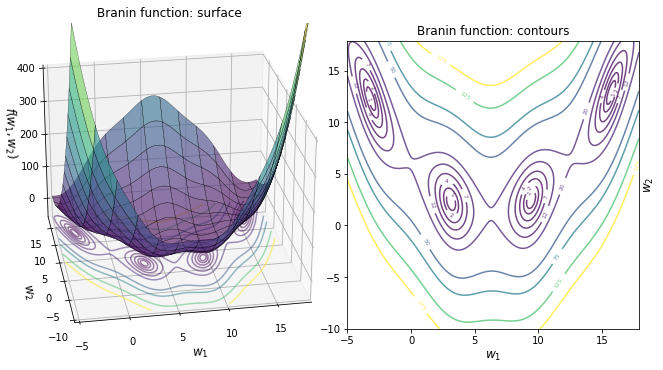

In [3]:
import matplotlib.pyplot as plt

# Visualize the Branin function in 3d
fig = plt.figure(figsize=(9, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_position([0.025, 0.15, 0.5, 0.9])

ax.plot_surface(w1, w2, z, rstride=20, cstride=20, alpha=0.6, linewidth=0.25, edgecolors='k', cmap='viridis')
ax.view_init(elev=25.0, azim=-100.0)
ax.contour(w1, w2, z, zdir='z', levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), 
           offset=-50, cmap='viridis', alpha=0.5)

ax.set_xlabel('$w_1$', fontsize=12)
ax.set_xlim(w1Min, w1Max)
ax.set_ylabel('$w_2$', fontsize=12)
ax.set_ylim(w2Min, w2Max)
ax.set_zlabel('$f(w_1, w_2)$', fontsize=12)
ax.set_zlim(-50, 400)
ax.set_zticks([0, 100, 200, 300, 400])
ax.dist = 9
ax.set_title('Branin function: surface', fontsize=12);

# Visualize the Branin function in 2d
ax = fig.add_subplot(1, 2, 2)
ax.set_position([0.55, 0.2, 0.45, 0.8])

ctr = ax.contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), cmap='viridis', alpha=0.75)
ax.clabel(ctr, inline=1, fontsize=6)
ax.set_xlabel('$w_1$', fontsize=12)
ax.set_ylabel('$w_2$', fontsize=12)
ax.yaxis.set_label_position("right")
ax.set_title('Branin function: contours', fontsize=12);

# plt.savefig('./figures/CH05_F02_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
# plt.savefig('./figures/CH05_F02_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')

This function has **four global minima**, which are the centers of the elliptical regions in contours. Gradient descent will aim to find one of these four global minima. 


Gradient descent performs the following steps:

Initialize: ``x_old`` = initial guess
while not converged:
    1. compute the negative gradient and normalize to unit length (direction)
    2. compute the step length using line search (distance)
    3. update the solution: x_new = x_old + distance * direction
    4. check for convergence: if amount of change between x_new and x_old is below our tolerance threshold
    
We can implement a basic version of gradient descent that can take a function $f$ and corresponding gradient $g$ as input and returns a locally optimal solution.

**Listing 5.1**: Gradient Descent    

In [4]:
from scipy.optimize import line_search

# Gradient descent with function f, and gradient g
def gradient_descent(f, g, x_init, max_iter=100, args=()):
    converged = False
    n_iter = 0

    x_old, x_new = np.array(x_init), None
    descent_path = np.full((max_iter + 1, 2), fill_value=np.nan)   # Save the descent path
    descent_path[n_iter] = x_old

    while not converged:
        n_iter += 1
        gradient = -g(x_old, *args)                                # Compute the negative gradient
        direction = gradient / np.linalg.norm(gradient)            # Normalize the gradient 
        step = line_search(f, g, x_old, direction, args=args)      # Compute the step length using line search

        if step[0] is None:                     # If step length doesn't return a useful value, make it 1.0
            distance = 1.0
        else:
            distance = step[0]

        x_new = x_old + distance * direction                    # Compute the update
        descent_path[n_iter] = x_new

        # Update status
        # print('Iter {0:02d}: obj value = {1} (step={2}, dir={3}'.format(n_iter, step[3], step[0], direction))

        err = np.linalg.norm(x_new - x_old)                        # Compute amount of change between x_new and x_old
        if err <= 1e-3 or n_iter >= max_iter:                      # Check for convergence
            converged = True

        x_old = x_new                                              # Get ready for the next iteration

    return x_new, descent_path

We perform gradient descent on the Branin function, intializing our solution at $w = [-4, -5]$, and visualize our solution path.

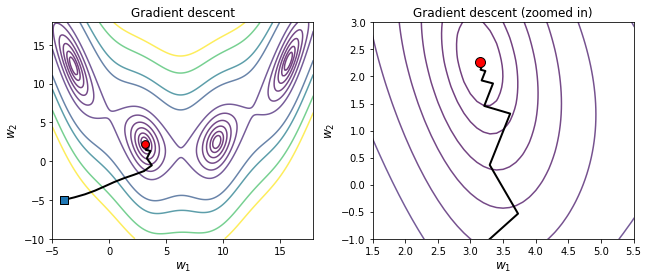

In [5]:
# Set the constants of the Branin function
a, b, c, r, s, t = 1, 5.1 / (4 * np.pi ** 2), 5 / np.pi, 6, 10, 1 / (8 * np.pi)

# Initialize and perform gradient descent
w_init = np.array([-4, -5])
w_optimal, w_path = gradient_descent(branin, branin_gradient, w_init, args=(a, b, c, r, s, t))

# Plot optimization path over all iterations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), cmap='viridis', alpha=0.75)
ax[0].plot(w_path[:, 0], w_path[:, 1], 'k', linewidth=2)
ax[0].scatter(w_init[0], w_init[1], s=60, marker='s', edgecolor='k', zorder=2)
ax[0].scatter(w_optimal[0], w_optimal[1], s=60, c='r', edgecolor='k', zorder=2)
ax[0].set_xlabel('$w_1$', fontsize=12)
ax[0].set_ylabel('$w_2$', fontsize=12)
ax[0].set_title('Gradient descent', fontsize=12)

# Plot optimization path zoomed in
ax[1].contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), cmap='viridis', alpha=0.75)
ax[1].plot(w_path[:, 0], w_path[:, 1], 'k', linewidth=2)
ax[1].scatter(w_optimal[0], w_optimal[1], s=100, c='r', edgecolor='k', zorder=2)
ax[1].set_xlim(1.5, 5.5)
ax[1].set_ylim(-1, 3)
ax[1].set_xlabel('$w_1$', fontsize=12)
ax[1].set_ylabel('$w_2$', fontsize=12)
ax[1].set_title('Gradient descent (zoomed in)', fontsize=12)

fig.tight_layout()
# plt.savefig('./figures/CH05_F03_Kunapuli.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('./figures/CH05_F03_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)

Two important things to note here:
1. **Gradient descent typically demonstrates zig-zagging behavior**, especially in narrow valleys. This is a consequence of rapidly changing gradient direction. The magnitude of the gradient also becomes smaller as we approach the minima.

2. Of the four minima, which one will gradient descent converge to? That depends on the initial guess. As we see below, **different initializations will cause gradient descent to reach different minima**.

C:\Python310\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


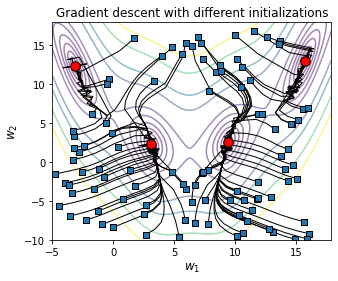

In [6]:
n = 25
inits = np.r_[np.c_[np.random.uniform(-5, 1, n), np.random.uniform(-10, 7, n)],
              np.c_[np.random.uniform(1, 11, n), np.random.uniform(-10, -1, n)],
              np.c_[np.random.uniform(11, 17, n), np.random.uniform(-10, 7, n)],
              np.c_[np.random.uniform(-2, 14, n), np.random.uniform(9, 17, n)]
             ]


plt.figure(figsize=(5, 4))
plt.contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), cmap='viridis', alpha=0.5)

minima = []
# For each initialization, optimize and plot the path
for i, w_init in enumerate(inits):
    w, path = gradient_descent(branin, branin_gradient, w_init, args=(a, b, c, r, s, t))
    plt.plot(path[:, 0], path[:, 1], 'k', linewidth=1)
    minima.append(w)
    
minima = np.array(minima)
from sklearn.cluster import KMeans
opt = KMeans(n_clusters=4).fit(minima)
minima = opt.cluster_centers_

plt.scatter(inits[:, 0], inits[:, 1], s=30, marker='s', edgecolor='k', zorder=2)
plt.scatter(minima[:, 0], minima[:, 1], c='r', s=90, marker='o', edgecolor='k', zorder=2)    
plt.xlabel('$w_1$', fontsize=12)
plt.ylabel('$w_2$', fontsize=12)
plt.title('Gradient descent with different initializations', fontsize=12);

fig.tight_layout()
# plt.savefig('./figures/CH05_F04_Kunapuli.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('./figures/CH05_F04_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)

---
### 5.1.2	Gradient Descent over Loss Functions for Training

Let's consider a simple classification problem in a two-dimensional feature space

In [7]:
import matplotlib.cm as cm
import matplotlib.colors as col
import numpy as np

# Plot a 2D classification data set onto the specified axes
def plot_2d_data(ax, X, y, s=20, alpha=0.95, xlabel=None, ylabel=None, title=None, legend=None, colormap='viridis'):
    # Get data set size
    n_examples, n_features = X.shape

    # Check that the data set is 2D
    if n_features != 2:
        raise ValueError('Data set is not 2D!')

    # Check that the lengths of X and y match
    if n_examples != len(y):
        raise ValueError('Length of X is not equal to the length of y!')

    # Get the unique labels and set up marker styles and colors
    unique_labels = np.sort(np.unique(y))
    n_classes = len(unique_labels)

    markers = ['o', 's', '^', 'v', '<', '>', 'p']

    cmap = cm.get_cmap(colormap)
    colors = cmap(np.linspace(0, 0.5, num=n_classes))

    # Set marker sizes
    if isinstance(s, np.ndarray):
        # If its an ndarray, make sure it has the same size as the number of examples
        if len(s) != n_examples:
            raise ValueError('Length of s is not equal to the length of y!')
    else:
        # Otherwise, make it an nd_array
        s = np.full_like(y, fill_value=s)

    # Plot the data
    for i, label in enumerate(unique_labels):
        marker_color = col.rgb2hex(colors[i])
        marker_shape = markers[i % len(markers)]
        ax.scatter(X[y == label, 0], X[y == label, 1], s=s[y == label],
                   marker=marker_shape, 
                   c=marker_color, 
                   edgecolors='k', alpha=0.5)

    # Add labels, title and bounds
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=12)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=12)
    if title is not None:
        ax.set_title(title)

    # Set the legend
    if legend is not None:
        ax.legend(legend, fontsize=12);

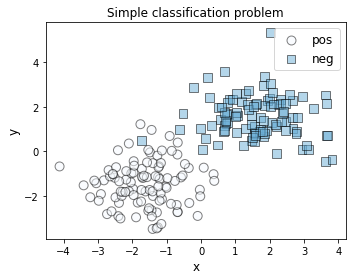

In [8]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, n_features=2, 
                  centers=[[-1.5, -1.5], [1.5, 1.5]], random_state=42)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
plot_2d_data(ax, X, y, xlabel='x', ylabel='y', s=80, alpha=0.3,
             title='Simple classification problem', 
             legend=['pos', 'neg'], colormap='Blues')

fig.tight_layout()
# plt.savefig('./figures/CH05_F05_Kunapuli.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('./figures/CH05_F05_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)

Now, let's say that we want to learn a linear classifier $h(\mathbf{x})$ of the form shown below:

\\[
h_\mathbf{w}(\mathbf{x}) = w_1 x_1 + w_2 x_2,
\\]

which takes a training example $\mathbf{x} = [x_1, x_2]^T$. The classifier is parameterized by $\mathbf{w} = [w_1, w_2]^T$, which we have to learn using the training examples. In order to train a classifier, we'll need a loss function. 

For this problem, we will chose the **squared loss** of the classifier $h_\mathbf{w}(\mathbf{x})$ over the training set of $n$ training examples $\mathbf{x}_i = [x_1^i, x_2^i]^T$, $i=1, ..., n$, with corresponding labels $y_i$.

\\[
f_{loss}(w_1, w_2) = \frac{1}{2} \sum_{i=1}^n \left( y_i - h_\mathbf{w}(\mathbf{x}_i) \right)^2 = \frac{1}{2} \sum_{i=1}^n \left( y_i - w_1 x_1^i - w_2 x_2^i \right)^2 = \frac{1}{2} (\mathbf{y} - X\mathbf{w})^T (\mathbf{y} - X\mathbf{w}).
\\]

Similar to the Branin function in Section 5.2.1, we can compute the gradient of this loss function with respect to $w_1$ and $w_2$.

\\[
g(w_1, w_2) = \left[ \begin{array}{c} 
    \frac{\partial f_{loss}(w_1, w_2)}{\partial w_1} \\ 
    \frac{\partial f_{loss}(w_1, w_2)}{\partial w_2} 
    \end{array} \right] 
    = \left[ \begin{array}{c} 
    - \sum_{i=1}^n \left( y_i - w_1 x_1 - w_2 x_2 \right) x_1\\ 
    - \sum_{i=1}^n \left( y_i - w_1 x_1 - w_2 x_2 \right) x_2 \end{array} \right]
    = -X^T (\mathbf{y} - X\mathbf{w})
\\]

In both the equations above, the expressions on the far right are the vectorized versions of the loss function, where $X$ is the data matrix and $\mathbf{y}$ is the label vector. The vectorized version is more compact and easier and more efficient to implement as it avoids explicit loops for summation. 

In [9]:
def squared_loss(w, X, y):
    return 0.5 * np.sum((y - np.dot(X, w))**2)


def squared_loss_gradient(w, X, y):
    return -np.dot(X.T, (y - np.dot(X, w)))

As before, we visualize the function we want to optimize.

C:\Users\gauta\AppData\Local\Temp\ipykernel_29192\438382105.py:22: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8


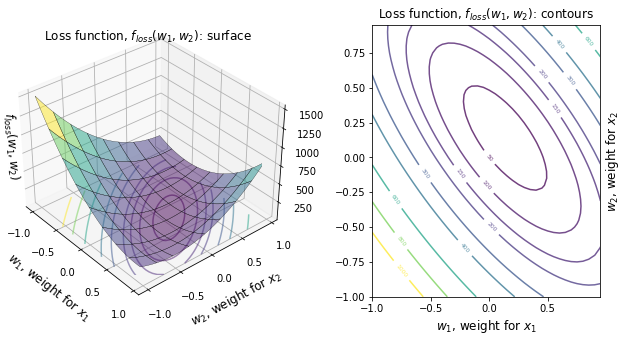

In [10]:
# %matplotlib inline

fig = plt.figure(figsize=(9, 5))

# Plot the loss function
w1Min, w1Max, w2Min, w2Max = -1, 1, -1, 1
w1, w2 = np.meshgrid(np.arange(w1Min, w1Max, 0.05),
                     np.arange(w2Min, w2Max, 0.05))
z = np.apply_along_axis(squared_loss, 1, np.c_[w1.ravel(), w2.ravel()], X, y)
z = z.reshape(w1.shape)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(w1, w2, z, rstride=5, cstride=5, alpha=0.5, linewidth=0.25, edgecolors='k', cmap='viridis')
ax.view_init(elev=34, azim=-40.0)
ax.contour(w1, w2, z, zdir='z', levels=np.array([50, 100, 150, 200, 300, 400, 600, 800, 1000]),
           offset=-50, cmap='viridis', alpha=0.5)
ax.set_xlabel('$w_1$, weight for $x_1$', fontsize=12)
ax.set_ylabel('$w_2$, weight for $x_2$', fontsize=12)
# ax.set_zlabel('$L(w)$ ', fontsize=12)
ax.text(-1.3, -1.4, 450, '$f_{loss}(w_1, w_2)$', (0, 0, 1), fontsize=12)

ax.dist = 8
ax.set_title('Loss function, $f_{loss}(w_1, w_2)$: surface', fontsize=12)
# pos1 = ax.get_position() # get the original position 
# pos2 = [pos1.x0 - 0.1, pos1.y0,  pos1.width, pos1.height] 
# ax.set_position(pos2) # set a new position

# Plot the contour
ax = fig.add_subplot(1, 2, 2)
ctr = ax.contour(w1, w2, z, levels=np.array([50, 100, 150, 200, 300, 400, 600, 800, 1000]),
                 cmap='viridis', alpha=0.75)
ax.clabel(ctr, inline=1, fontsize=6)
ax.set_xlabel('$w_1$, weight for $x_1$', fontsize=12)
ax.set_ylabel('$w_2$, weight for $x_2$', fontsize=12)
ax.set_title('Loss function, $f_{loss}(w_1, w_2)$: contours', fontsize=12)
ax.yaxis.set_label_position("right")
pos1 = ax.get_position() # get the original position 
pos2 = [pos1.x0 + 0.1, pos1.y0, pos1.width, pos1.height] 
ax.set_position(pos2) # set a new position


# fig.tight_layout()
# plt.savefig('./figures/CH05_F06_Kunapuli.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('./figures/CH05_F06_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)

As before, we perform gradient descent, this time initializing at $\mathbf{w} = [0.0, -0.99]$.

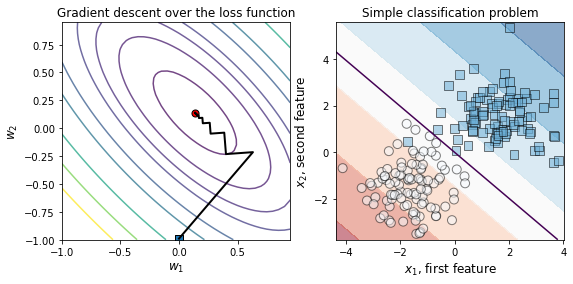

In [11]:
%matplotlib inline

w_init = np.array([0.0, -0.99])
w, path = gradient_descent(squared_loss, squared_loss_gradient, w_init, args=(X, y))

# Compute the Loss function in this domain
w1Min, w1Max, w2Min, w2Max = -1, 1, -1, 1
w1, w2 = np.meshgrid(np.arange(w1Min, w1Max, 0.05),
                     np.arange(w2Min, w2Max, 0.05))
z = np.apply_along_axis(squared_loss, 1, np.c_[w1.ravel(), w2.ravel()], X, y)
z = z.reshape(w1.shape)

# Plot optimization path over all iterations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].contour(w1, w2, z, levels=np.array([25, 50, 100, 150, 200, 300, 400, 600, 800, 1000]),
              cmap='viridis', alpha=0.75)
ax[0].scatter(w_init[0], w_init[1], s=60, marker='s', zorder=2, edgecolor='k')
ax[0].scatter(w[0], w[1], c='r', s=50, zorder=2, edgecolor='k')
ax[0].plot(path[:, 0], path[:, 1], 'k', linewidth=2)
ax[0].set_xlabel('$w_1$', fontsize=12)
ax[0].set_ylabel('$w_2$', fontsize=12)
ax[0].set_title('Gradient descent over the loss function', fontsize=12)

# Plot the solution
xMin, xMax = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
yMin, yMax = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05),
                           np.arange(yMin, yMax, 0.05))
zMesh = np.dot(np.c_[xMesh.ravel(), yMesh.ravel()], w)
zMesh = (zMesh.reshape(xMesh.shape) + 1) / 2
ax[1].contourf(xMesh, yMesh, zMesh, cmap='RdBu', alpha=0.5)
ax[1].contour(xMesh, yMesh, zMesh, levels=[0.5])
plot_2d_data(ax[1], X, y, colormap='Blues', s=80, alpha=0.4)
ax[1].set_xlabel('$x_1$, first feature', fontsize=12)
ax[1].set_ylabel('$x_2$, second feature', fontsize=12)
ax[1].set_title('Simple classification problem', fontsize=12);

# fig.tight_layout()
# plt.savefig('./figures/CH05_F07_Kunapuli.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('./figures/CH05_F07_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [12]:
print(w)

[0.13643511 0.13862275]


The final $\mathbf{w}$ is trained by performing gradient descent on the loss function defined over the training examples. From the figure on the right above, we can see that gradient descent does, in fact, produce a nice fit.

In [13]:
ypred = (np.dot(X, w) >= 0).astype(int)
from sklearn.metrics import accuracy_score
accuracy_score(y, ypred)

0.995